# Feed-forward Loop

## General helper functions

In [2]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    'mathtext.fontset': 'stix',
    "font.family": 'STIXGeneral',
    "axes.labelpad": 8.0
})

# helper functions
def pAct(C, Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):
    """ probability of repressor/activator being active
    
    Parameters:
        - C: inducer concentration
        - Ka: dissociation constant in active state
        - Ki: dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p = (1 + C/Ka)**2 / ((1 + C/Ka)**2 + np.exp(-delE)*(1 + C/Ki)**2)
    return p

def pActEC50(Ka=1.4*10**(-4), Ki=5.3*10**(-7), delE=4.5):

    a = (1/Ka**2 - np.exp(-delE)/Ki**2)
    b = 2*(1/Ka - np.exp(-delE)/Ki)
    c = 1 - np.exp(-delE)

    sols = np.roots([a, b, c])
    C = sols[sols > 0][0]

    dc = 10**(-7)
    dpdc = C*(pAct(C + dc) - pAct(C))/dc
    y = 1/2 - dpdc * np.log(C)

    print([C, dpdc, y])
    return [C, dpdc, y]

def normalize(x):
    """ Normalize an array such that 
    min(x) = 0
    max(x) = 1
    """
    return (x - min(x)) / (max(x) - min(x))

def normalize_pulse(x, xmax, xmin):
    """ Normalize an array such that 
    min(x) = 0
    max(x) = 1
    """
    print(xmin, xmax)
    return (x - xmin) / (xmax - xmin)

### Coherent feed-forward loop functions

In [4]:
def steadyStateFeedForward(X, rys, rzs, w, px, py, Ks):
    
    Kxy, Kxz, Kyz = Ks

    Y = (rys[0] + rys[1]*px*X/Kxy)/(1 + px*X/Kxy)
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)

    if type(Y) is np.float64:
        return np.array([X, Y, Z])
    else:
        Xarray = np.full_like(Y, X)
        return [Xarray, Y, Z]

def steadyStateSimpleReg(X, Y, rzs, w, px, py, Ks):

    Kxy, Kxz, Kyz = Ks
    
    Z = (rzs[0] + rzs[1]*(px*X/Kxz + py*Y/Kyz) +\
                             w*rzs[2]*px*X/Kxz*py*Y/Kyz)/(1 + px*X/Kxz + py*Y/Kyz + w*px*X/Kxz*py*Y/Kyz)
    
    return np.array([X, Y, Z])

def evolveFeedForward(Rs, rys, rzs, w, px, py, delt, Ks):

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    dRsdt[1] = - Rs[1] + (rys[0] + rys[1]*px*Rs[0]/Kxy)/(1 + px*Rs[0]/Kxy)
    dRsdt[2] = - Rs[2] + (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def evolveSimpleReg(Rs, rys, rzs, w, px, py, delt, Ks):

    Kxy, Kxz, Kyz = Ks

    dRsdt = np.zeros_like(Rs)
    activation = (rzs[0] + rzs[1]*(px*Rs[0]/Kxz + py*Rs[1]/Kyz) +\
                             w*rzs[2]*px*Rs[0]/Kxz*py*Rs[1]/Kyz)/(1 + px*Rs[0]/Kxz + py*Rs[1]/Kyz + w*px*Rs[0]/Kxz*py*Rs[1]/Kyz)
    dRsdt[2] = - Rs[2] + activation
    
    Rs_new = Rs + dRsdt * delt

    return Rs_new

def analytic_Z(ts, rs, w, X, yinit, yinf, z0):

    r0, r1, r2 = rs
    y0 = yinf
    y1 = yinit - yinf

    integral = 1/(1 + X + y0 + w*X*y0)**2 * (np.exp(ts) * (1 + X + y0 + w*X*y0)*\
                        (r0 + r1*(X + y0) + r2*w*X*y0) - (r0*(1+w*X) - r2*w*X*(1+X) +\
                        r1*(-1+w*X**2)) * y1 * np.log(np.exp(ts)*(1 + X + y0*(1 + w*X)) + y1*(1 + w*X)))
    integral0 = 1/(1 + X + y0 + w*X*y0)**2 * ((1 + X + y0 + w*X*y0)*\
                        (r0 + r1*(X + y0) + r2*w*X*y0) - (r0*(1+w*X) - r2*w*X*(1+X) +\
                        r1*(-1+w*X**2)) * y1 * np.log((1 + X + y0*(1 + w*X)) + y1*(1 + w*X)))
    zs = np.exp(-ts)*(integral - integral0 + z0)

    return zs

def diff_func(ts, rs, w, X, delY, Yinf):
    
    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    chi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    
    return np.exp(-ts)*(chi*delY/S**2)*np.log((S*np.exp(ts) + delY*(1 + w*X))/(S + delY*(1 + w*X)))

def int_delta(rs, w, X, delY, Yinf):

    r0, r1, r2 = rs

    S = 1 + X + Yinf + w*X*Yinf
    Phi = (r1 + r2*w*X*(1 + X)) - (r0*(1 + w*X) + r1*w*X**2)
    return Phi/(S*(1 + w*X))*np.log(1 + delY * (1+w*X) / S)

## Fig. 21(A)

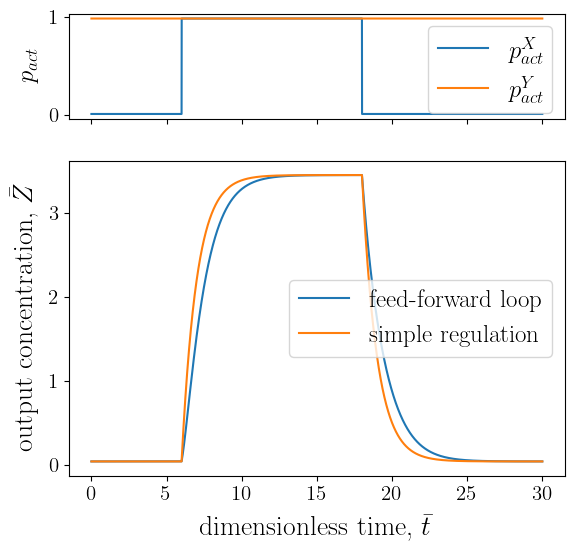

In [6]:
# Delay in coherent feed-forward loop response compared to simple regulation

nstep = 3*10**4
delt = 10**(-3)

ts = np.linspace(0, nstep*delt, nstep)

rys = [0, 2]
rzs = [0, 2, 10]
w = 1

Ks = [1, 1, 1]

# defining how inducer concentration is tuned

pmin = pAct(10**(-4))
pmax = pAct(10**(-7))

empty = np.full(int(nstep/5), pmin)
full = np.full(int(nstep/5), pmax)
# empty = np.full(int(nstep/5), 0)
# full = np.full(int(nstep/5), 1)

pxs = np.concatenate((empty, full, full, empty, empty))
pys = np.full(nstep, pmax)

X, Y = 1, 1

Rs = np.zeros((nstep, 3))
Rs[0, :] = steadyStateFeedForward(X, rys, rzs, w, pxs[0], pys[0], Ks)

Rps = np.copy(Rs)
Rps[0, :] = steadyStateSimpleReg(X, Y, rzs, w, pxs[0], pys[0], Ks)

for i in range(nstep-1):
    
    px = pxs[i]
    py = pys[i]

    Rs[i+1, :] = evolveFeedForward(Rs[i, :], rys, rzs, w, px, py, delt, Ks)
    Rps[i+1, :] = evolveSimpleReg(Rps[i, :], [0, 0], rzs, w, px, py, delt, Ks)

fig, axs = plt.subplots(2, 1, figsize=(6.4, 6), height_ratios=[0.25, 0.75])

axs[0].plot(ts, pxs, label=r"$p_{act}^X$")
axs[0].plot(ts, pys, label=r"$p_{act}^Y$")
axs[0].set_ylabel(r"$p_{act}$", fontsize=18)
axs[0].legend()
axs[0].xaxis.set_ticklabels([])

axs[1].plot(ts, Rs[:, 2], label=r"feed-forward loop")
axs[1].plot(ts, normalize(Rps[:, 2])*(np.max(Rs[:, 2]) - np.min(Rs[:, 2])) + np.min(Rs[:, 2]), label=r"simple regulation")
axs[1].set_xlabel(r"dimensionless time, $\bar{t}$")
axs[1].set_ylabel(r"output concentration, $\bar{Z}$")
axs[1].legend(loc="center right")
fig.align_labels()
plt.show()

## Fig. 22

### (A)(i)

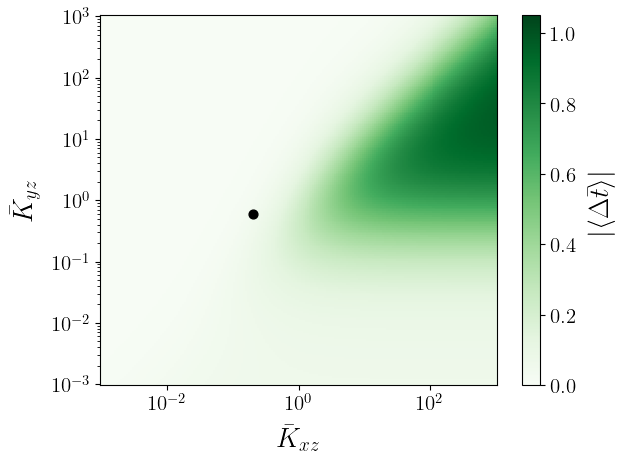

In [8]:
# XOR GATE, ON STEP

rys = [0, 2]
rzs = [0, 2, 0]
w = 0

length = 200

plow = pAct(10**(-4))
phigh = pAct(10**(-7))

# creating 2d mesh
Kxzs = np.logspace(-3, 3, length)
Kyzs = np.logspace(-3, 3, length)

KX, KY = np.meshgrid(Kxzs, Kyzs)
KXY = np.full_like(KX, 1)
Ks = [KXY, KX, KY]

Xs = np.full_like(KX, 1)

[_, lowY, lowZ] = steadyStateFeedForward(Xs, rys, rzs, w, plow, phigh, Ks)
[_, highY, highZ] = steadyStateFeedForward(Xs, rys, rzs, w, phigh, phigh, Ks)

delta = np.abs(int_delta(rzs, w, phigh*1/KX, (lowY - highY)/KY, highY/KY))

timescale = delta/(highZ - lowZ)
fig, ax = plt.subplots()
im = ax.pcolormesh(KX, KY, timescale, cmap="Greens", rasterized = True, vmin=0, vmax=1.05)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\bar{K}_{xz}$")
ax.set_ylabel(r"$\bar{K}_{yz}$")
ax.scatter(0.2, 0.6, s = 40, c="black")
cbar = plt.colorbar(im)
cbar.set_label(r"$|\langle\Delta \bar{t}\rangle|$")
# plt.savefig(r"C:\Users\alber\Desktop\Phillips Group\codes\graphs\20250218\FFL_time_xor_on.pdf", format="pdf", bbox_inches="tight")
plt.show()